In [134]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

In [135]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [136]:
from torch.utils.data import DataLoader

In [137]:
def dataloader(train_dataset, test_dataset, batch_size):
    return (
        DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True), 
        DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False),
        train_dataset.classes
    )

In [138]:
BATCH_SIZE = 64
train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [139]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [140]:
# new conv
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [141]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None, norm=norm, bias=True), 
        nn.Flatten()
    ).to(device)

In [142]:
model = get_model(norm=nn.BatchNorm2d)

In [143]:
lr = 6e-2
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

In [144]:
from torcheval.metrics import MulticlassAccuracy, Mean
accuracy_metric = MulticlassAccuracy(device=device)
loss_metric = Mean(device=device)

In [145]:
# in utils or join it?
def compute_result(mode, epoch, loss_metric, accuracy_metric):
    result = {
        "epoch": epoch,
        "mode": mode,
        "loss": loss_metric.compute().item(),
        "accuracy": accuracy_metric.compute().item()
    }
    print(f"{result['epoch']}\t{result['mode']}\t{result['loss']:.4f}\t{result['accuracy']:.4f}")
    loss_metric.reset()
    accuracy_metric.reset()
    return result


In [146]:
# new train.py
from tqdm.notebook import tqdm_notebook
from IPython.display import display

def fit(epochs, model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, device):
    model.to(device)
    results = []

    progress_bar = trange(epochs, desc="Progress")
    display(progress_bar)
    print("Epoch\tMode\tLoss\tAccuracy")

    for epoch in progress_bar:
        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            loss_metric.update(loss)    
            accuracy_metric.update(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
        
        results.append(compute_result("train", epoch, loss_metric, accuracy_metric))

        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss_fn(pred, y)
                loss_metric.update(loss)
                accuracy_metric.update(pred, y)
            results.append(compute_result("test", epoch, loss_metric, accuracy_metric))
                        
        scheduler.step()
        
    return results

In [147]:
results = fit(
    epochs=epochs, 
    model=model, 
    train_dataloader=train_dataloader, 
    test_dataloader=test_dataloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    device=device
)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy
0	train	0.4785	0.8601
0	test	0.5192	0.8870
1	train	0.3120	0.8971
1	test	0.4362	0.9006
2	train	0.2657	0.9089
2	test	0.2880	0.9001
3	train	0.2337	0.9190
3	test	0.1958	0.9096
4	train	0.2101	0.9264
4	test	0.2487	0.9099


In [156]:
# in utils.py
import matplotlib.pyplot as plt

def plot_curves(loss, epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss)
    plt.xlabel('Epochs')
    plt.ylabel("loss")
    plt.legend()
    plt.show()

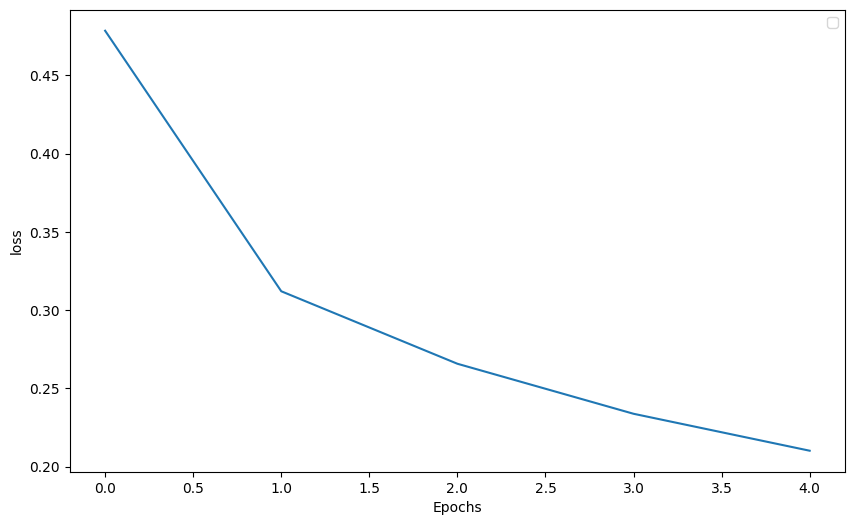

In [157]:
loss = []
epochs = []
for result in results:
    if result['mode'] == "train":
        loss.append(result["loss"])
        epochs.append(result["epoch"])
plot_curves(loss, epochs)